<a href="https://colab.research.google.com/github/litaPhsinaM/Object-Detection-on-VR_Manish-Patil/blob/main/cnn_3d_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import h5py
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor

In [5]:
# load dataset
source_data = h5py.File('/content/drive/MyDrive/CNN-3D-Shapes_mpatil2/3dshapes.h5', 'r')
print(source_data.keys())
source_images = source_data['images']  # array shape [480000,64,64,3], uint8 in range(256)
source_labels = source_data['labels']  # array shape [480000,6], float64
labels = source_labels[:,4]
labels = list(labels.astype(int))

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [7]:
LABEL_MAP = {
    0: "Cube",
    1: "Cylinder",
    2: "Sphere",
    3: "Capsule"
}

In [8]:
source_images

<HDF5 dataset "images": shape (480000, 64, 64, 3), type "|u1">

In [9]:
# Select how many data points to use
SAMPLE_SIZE = 4800
use_images = source_images[0:SAMPLE_SIZE]

In [10]:
# Convert the PIL image to tensors
to_tensor = ToTensor()

images_tensor = torch.stack([to_tensor(image) for image in use_images])
labels_list = labels[0:SAMPLE_SIZE]

In [11]:
dataset = list(zip(images_tensor, labels_list))

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 64x64 px color images with 3 channels (RGB), each image tensor has the shape `(3, 64, 64)`.

In [12]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6000, 0.6000, 0.6000,  ..., 0.6000, 0.6000, 0.6000],
         [0.6000, 0.6000, 0.6000,  ..., 0.6000, 0.6000, 0.6000],
         [0.6000, 0.6000, 0.6000,  ..., 0.6000, 0.6000, 0.6000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9216, 0.9294, 0.9255],
         [1.0000, 1.0000, 1.0000,  ..., 0.9020, 0.8824, 0.9059],
         [1.0000, 1.0000, 1.0000,  ..., 0.9020, 0.9059, 0.9412]],

        [[0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.8863],
         [0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.8863],
         [0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.8863],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
         [0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
         [0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.

We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(64,64,3)`. Let's create a helper function to display an image and its label.

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
def show_example(img, label):
    print('Label: ', label, "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell, the 64x64px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label:  0 (0)


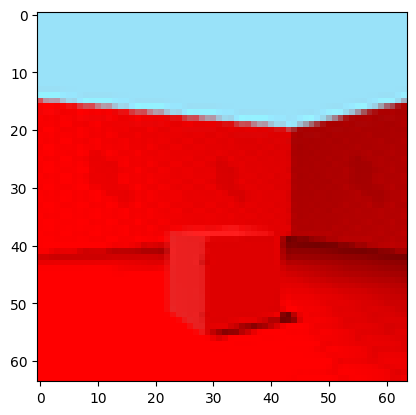

In [15]:
show_example(*dataset[0])

Label:  3 (3)


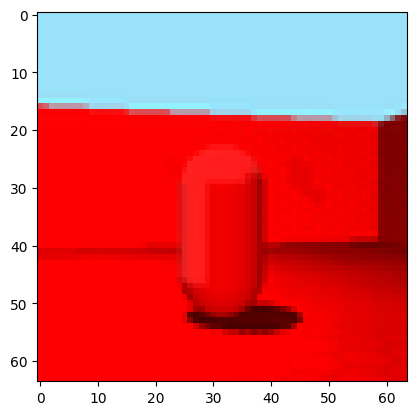

In [16]:
show_example(*dataset[109])

## Training, Test, Val split

In [17]:
random_seed = 42
torch.manual_seed(random_seed);

In [18]:
test_size = int(len(dataset)*0.1)

train_size = len(dataset) - test_size

train_ds_source, test_ds = random_split(dataset, [train_size, test_size])

val_size = int(len(train_ds_source)*0.1)
final_train_size = len(train_ds_source) - val_size
train_ds, val_ds = random_split(train_ds_source, [final_train_size, val_size])

len(train_ds), len(val_ds), len(test_ds)

(3888, 432, 480)

We can now create data loaders for training and validation, to load the data in batches

In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

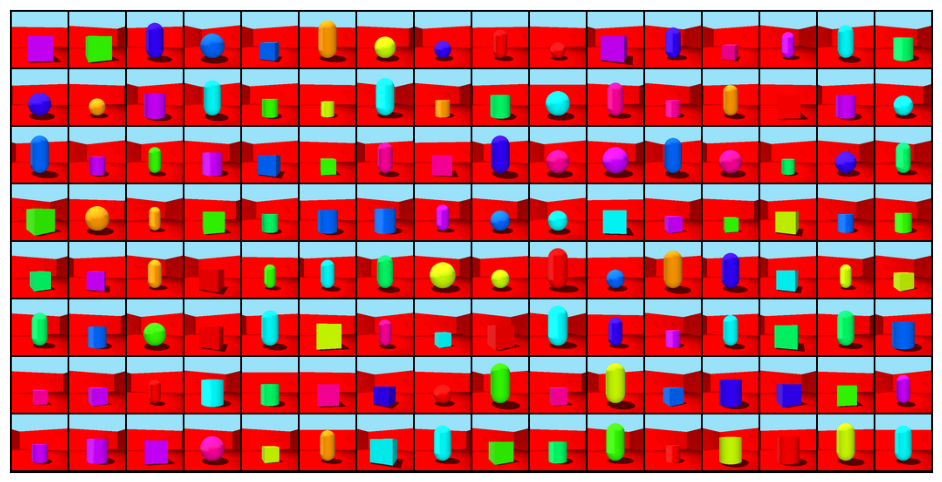

In [22]:
show_batch(train_dl)

### Training setup

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [25]:
class CustomCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4)) # output layer with 4 units
        
    def forward(self, xb):
        return self.network(xb)


In [26]:
model = CustomCnnModel()
model

CustomCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [27]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 4])
out[0]: tensor([ 0.0359,  0.0235, -0.0150, -0.0013], grad_fn=<SelectBackward0>)


In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

## Training the Model

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
model = to_device(CustomCnnModel(), device)

In [33]:
# baseline accuracy on validation data
evaluate(model, val_dl)

{'val_loss': 1.3852794170379639, 'val_acc': 0.2757457494735718}

The initial accuracy is around 25%, which is what one might expect from a randomly intialized model (since it has a 1 in 4 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [34]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [35]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1718, val_loss: 0.7759, val_acc: 0.6055
Epoch [1], train_loss: 0.3456, val_loss: 0.1174, val_acc: 0.9318
Epoch [2], train_loss: 0.2012, val_loss: 0.1171, val_acc: 0.9673
Epoch [3], train_loss: 0.0828, val_loss: 0.0382, val_acc: 0.9837
Epoch [4], train_loss: 0.0261, val_loss: 0.0139, val_acc: 0.9952
Epoch [5], train_loss: 0.0131, val_loss: 0.0084, val_acc: 0.9980
Epoch [6], train_loss: 0.0123, val_loss: 0.0105, val_acc: 0.9980
Epoch [7], train_loss: 0.0230, val_loss: 0.0127, val_acc: 0.9933
Epoch [8], train_loss: 0.0100, val_loss: 0.1246, val_acc: 0.9654
Epoch [9], train_loss: 0.0101, val_loss: 0.0023, val_acc: 0.9980


We can also plot the valdation set accuracies to study how the model improves over time.

In [36]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

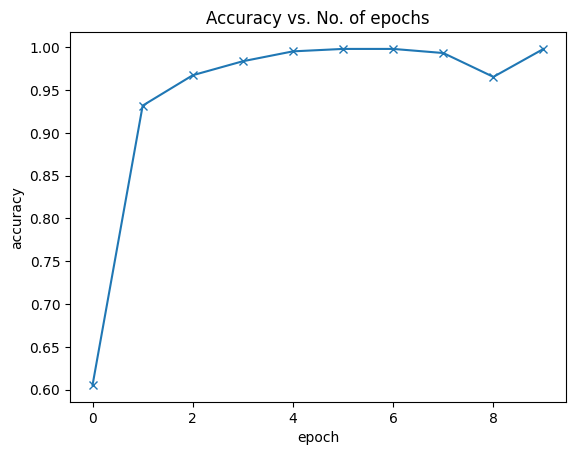

In [37]:
plot_accuracies(history)

In [38]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

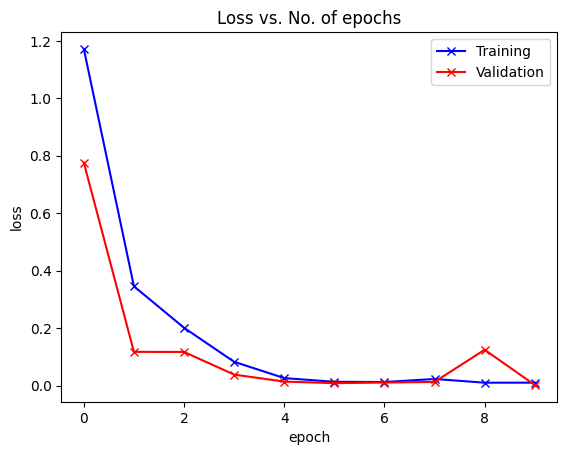

In [39]:
plot_losses(history)

## Testing with individual images


In [40]:
# for images, labels in test_dl:
#   print(images)
#   break

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [41]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return LABEL_MAP[preds[0].item()]

Label: Capsule , Predicted: Capsule


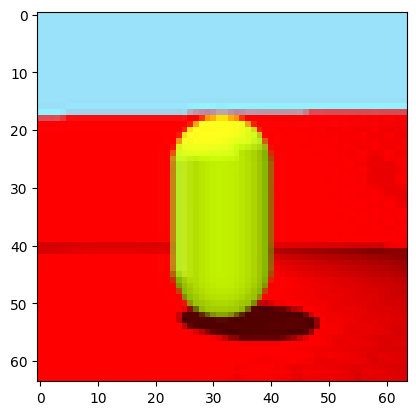

In [42]:
img, label = test_dl.dl.dataset[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', LABEL_MAP[label], ', Predicted:', predict_image(img, model))

Label: Cube , Predicted: Cube


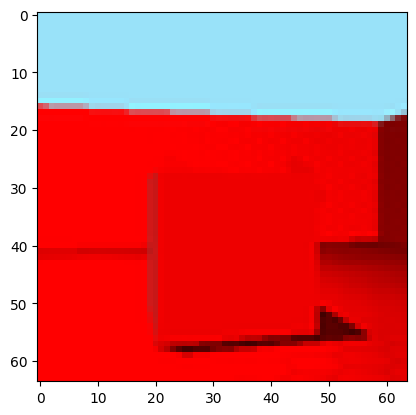

In [43]:
img, label = test_dl.dl.dataset[30]
plt.imshow(img.permute(1, 2, 0))
print('Label:', LABEL_MAP[label], ', Predicted:', predict_image(img, model))

Label: Sphere , Predicted: Sphere


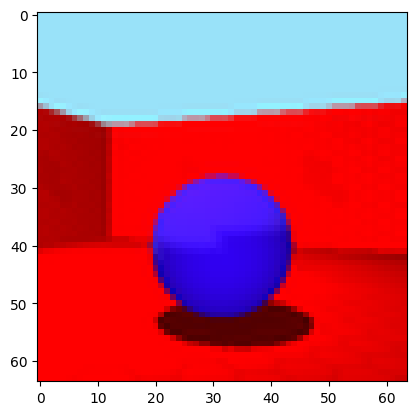

In [44]:
img, label = test_dl.dl.dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', LABEL_MAP[label], ', Predicted:', predict_image(img, model))

### Evaluate the model on test data

In [45]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.00672806054353714, 'val_acc': 0.9977678656578064}

## Saving and loading the model

In [46]:
torch.save(model.state_dict(), 'cnn3d-geo-object-detection.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [47]:
model2 = to_device(CustomCnnModel(), device)

In [48]:
model2.load_state_dict(torch.load('cnn3d-geo-object-detection.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [49]:
evaluate(model2, test_dl)

{'val_loss': 0.00672806054353714, 'val_acc': 0.9977678656578064}

In [50]:
# Finish